<a href="https://colab.research.google.com/github/shazzad-hasan/siamese-neural-networks/blob/main/siamese_omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/shazzad-hasan/few-shot-learning.git

Cloning into 'few-shot-learning'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 136 (delta 45), reused 60 (delta 19), pack-reused 0
Receiving objects: 100% (136/136), 47.63 KiB | 11.91 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/few-shot-learning/siamese_neural_network

/content/few-shot-learning/siamese_neural_network


In [ ]:
!ls

helper_dataset.py   helper_plot.py   siamese_omniglot.ipynb
helper_evaluate.py  helper_train.py


In [ ]:
# import required libraries
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split 
from torch.utils.data.sampler import SubsetRandomSampler 

import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# import local helper functions
from helper_dataset import OmniglotDataset, nWayOneShotValidSet
from helper_train import train
from helper_evaluate import test
from helper_plot import show_examples, plot_results

In [ ]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available!


In [ ]:
train_data = datasets.Omniglot(root="./data", download=True, transform=None)
test_data = datasets.Omniglot(root="./data", background = False, download=True, transform=None)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [ ]:
root_dir = '/content/few-shot-learning/siamese_neural_network/data/omniglot-py/images_evaluation/'
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

In [ ]:
data_size = 10000
# choose percentage of training data for validation
valid_pct = 0.2
valid_size = int(valid_pct * data_size)
train_size = data_size - valid_size

transform = transforms.Compose(
    [transforms.ToTensor()])

omniglot_data = OmniglotDataset(categories, root_dir, data_size, transform)
train_data, valid_data = random_split(omniglot_data, [train_size, valid_size])

## define dataloader parameters
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

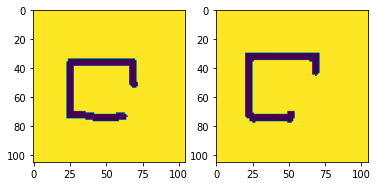

In [ ]:
show_examples(train_loader)

In [ ]:
test_size = 500
n_way = 4
batch_size = 1
num_workers = 0

test_data = nWayOneShotValidSet(categories, root_dir, test_size, n_way, transform)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# print out some data stats
print("Number of training images: ", len(train_data))
print("Number of validation images: ", len(valid_data))
print("Number of test images: ", len(test_data))

for img, _, _ in train_loader:
  print("Image batch dimension: ", img.shape)
  break

Number of training images:  8000
Number of validation images:  2000
Number of test images:  500
Image batch dimension:  torch.Size([128, 1, 105, 105])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    
    # Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(1, 64, 10)
    self.conv2 = nn.Conv2d(64, 128, 7)
    self.conv3 = nn.Conv2d(128, 128, 4)
    self.conv4 = nn.Conv2d(128, 256, 4)

    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(256)

    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.5)

    self.fc1 = nn.Linear(256*6*6, 4096)
    self.fc2 = nn.Linear(4096, 1)

  def convolution(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.max_pool2d(x, (2,2))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.max_pool2d(x, (2,2))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.max_pool2d(x, (2,2))
    x = F.relu(self.bn4(self.conv4(x)))

    return x

  def forward(self, x1, x2):
    x1 = self.convolution(x1)
    x2 = self.convolution(x2)

    # flatten input image
    x1 = x1.view(-1, 256*6*6)
    x2 = x2.view(-1, 256*6*6)

    x1 = torch.sigmoid(self.fc1(x1))
    x2 = torch.sigmoid(self.fc1(x2))

    x = torch.abs(x1 - x2)
    x = self.fc2(x)

    return x

model = SiameseNetwork()
model.to(device)
print(model)

SiameseNetwork(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

# specify a loss function
criterion = nn.BCEWithLogitsLoss() # categorical cross-entropy

# specify optimizer
params = model.parameters()
optimizer = optim.Adam(params, lr=0.001)

In [ ]:
num_epochs = 60
train_losses, valid_losses = train(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device)

Epochs: 1 	Training loss: 0.542932 	Validation loss: 0.462277
Validation loss decreased (inf --> 0.462277). Saving model ... 
Epochs: 2 	Training loss: 0.424522 	Validation loss: 0.396385
Validation loss decreased (0.462277 --> 0.396385). Saving model ... 
Epochs: 3 	Training loss: 0.375361 	Validation loss: 0.371044
Validation loss decreased (0.396385 --> 0.371044). Saving model ... 
Epochs: 4 	Training loss: 0.342333 	Validation loss: 0.337263
Validation loss decreased (0.371044 --> 0.337263). Saving model ... 
Epochs: 5 	Training loss: 0.323771 	Validation loss: 0.348876
Epochs: 6 	Training loss: 0.315974 	Validation loss: 0.321139
Validation loss decreased (0.337263 --> 0.321139). Saving model ... 
Epochs: 7 	Training loss: 0.293052 	Validation loss: 0.279487
Validation loss decreased (0.321139 --> 0.279487). Saving model ... 
Epochs: 8 	Training loss: 0.284556 	Validation loss: 0.268605
Validation loss decreased (0.279487 --> 0.268605). Saving model ... 
Epochs: 9 	Training loss: 

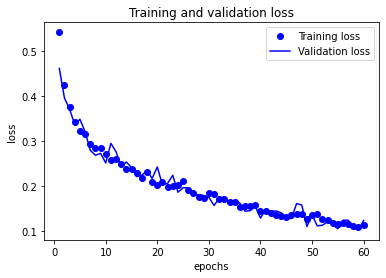

In [ ]:
# plot trainining and validation loss for each epoch
plot_results(train_losses, valid_losses, num_epochs)

In [ ]:
# load model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
test(model, test_loader, n_way, device)

Accuracy on 4 way: 0.9
Accuracy on 4 way: 0.925
Accuracy on 4 way: 0.9333333333333333
Accuracy on 4 way: 0.925
Accuracy on 4 way: 0.93
Accuracy on 4 way: 0.925
